In [1]:
#libraries
import numpy as np 
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

!pip install pydicom
import glob
import pydicom
from PIL import Image

# local imports
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 
import voxelmorph as vxm
import neurite as ne

# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19530 sha256=9d7120135bcc1ba2d1a47664937005659570705b233ce2d69b5b38bdfa3a3f4c
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def getImages(folder):
  os.chdir(f'/content/drive/My Drive/final_project_data/{folder}')
  images = []
  for img_path in glob.glob("*.JPG"):
    img = Image.open(img_path)
    img = img.resize((256,256))
    img = img.convert('L')
    images.append(img)
  for img_path in glob.glob("*.png"):
    img = Image.open(img_path)
    img = img.resize((256,256))
    img = img.convert('L')
    images.append(img)
  for img_path in glob.glob("*.jpg"):
    img = Image.open(img_path)
    img = img.resize((256,256))
    img = img.convert('L')
    images.append(img)
  return images

In [4]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim


class ImageRegistrationNet(nn.Module):
    def __init__(self):
        super(ImageRegistrationNet, self).__init__()

        # Contracting path
        self.contracting1 = self.contracting_block(3, 64)   # Contracting block 1
        self.contracting2 = self.contracting_block(64, 128)  # Contracting block 2
        self.contracting3 = self.contracting_block(128, 256) # Contracting block 3
        self.contracting4 = self.contracting_block(256, 512) # Contracting block 4

        # Expanding path
        self.expanding1 = self.expanding_block(512, 256)     # Expanding block 1
        self.expanding2 = self.expanding_block(256, 128)     # Expanding block 2
        self.expanding3 = self.expanding_block(128, 64)      # Expanding block 3

        # Final convolutional layer
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)     # Final convolutional layer

    def contracting_block(self, in_channels, out_channels):
        """
        Contracting block consists of two convolutional layers with ReLU activation and max pooling.
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        return block

    def expanding_block(self, in_channels, out_channels):
        """
        Expanding block consists of two convolutional layers with ReLU activation and transpose convolution for upsampling.
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, in_channels, kernel_size=2, stride=2)
        )
        return block

    def forward(self, x):
        # Contracting path
        print(x.shape)
        x1 = self.contracting1(x)                             # Apply contracting block 1
        print(f"x1: {x1.shape}")
        x2 = self.contracting2(x1)                            # Apply contracting block 2
        print(f"x2: {x2.shape}")
        x3 = self.contracting3(x2)                            # Apply contracting block 3
        print(f"x3: {x3.shape}")
        x4 = self.contracting4(x3)                            # Apply contracting block 4
        print(f"x4: {x4.shape}")

        # Expanding path
        x = self.expanding1(x4)                               # Apply expanding block 1
        print(f"x: {x.shape}")
        x = self.expanding2(torch.cat([x, x3], dim=1))        # Concatenate features from contracting block 3 and apply expanding block 2
        print(f"x: {x.shape}")
        x = self.expanding3(torch.cat([x, x2], dim=1))        # Concatenate features from contracting block 2 and apply expanding block 3
        print(f"x: {x.shape}")

        # Final convolution
        x = self.final_conv(x)                                # Apply final convolutional layer

        return x

In [25]:
def train(model, train_loader, optimizer,num_epochs,criterion):
    #criterion = nn.MSELoss()  # Example loss function, you can replace it with your own

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute the average loss for the epoch
        epoch_loss = running_loss / len(train_loader)

        # Print the loss for every epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import random

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),       # Resize the images to a fixed size
    #transforms.Grayscale(),               # Convert images to grayscale
    transforms.ToTensor()                  # Convert images to tensors
])

# Set the paths to your folders containing the images
folder1_path = "/content/drive/MyDrive/final_project_data/Posture/left"
folder2_path = "/content/drive/MyDrive/final_project_data/Posture/back"

# Create custom dataset class for paired images
class PairedImageDataset(Dataset):
    def __init__(self, folder1_path, folder2_path, transform=None):
        self.folder1_dataset = ImageFolder(folder1_path, transform=transform)
        self.folder2_dataset = ImageFolder(folder2_path, transform=transform)
        self.transform = transform

    def __getitem__(self, index):
        img1, _ = self.folder1_dataset[random.randint(0, len(self.folder1_dataset) - 1)]
        img2, _ = self.folder2_dataset[random.randint(0, len(self.folder2_dataset) - 1)]
        return img1, img2

    def __len__(self):
        return max(len(self.folder1_dataset), len(self.folder2_dataset))

# Create the paired dataset
paired_dataset = PairedImageDataset(folder1_path, folder2_path, transform=transform)

# Create the train_loader
batch_size = 1   # Set your desired batch size
train_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)


In [7]:
def Print2Loader(train_loader):
  first,second = next(iter(train_loader))
  print(first.shape)
  print(second.shape)

  # Create a figure with two subplots
  fig, axs = plt.subplots(1, 2)

  # Plot image1 in the first subplot
  first = first.squeeze().permute(1, 2, 0)
  second = second.squeeze().permute(1,2,0)
  axs[0].imshow(first)
  axs[0].axis('off')

  # Plot image2 in the second subplot
  axs[1].imshow(second)
  axs[1].axis('off')

  # Adjust the spacing between subplots
  plt.subplots_adjust(wspace=0.05)

  # Display the figure
  plt.show()

In [8]:
model = ImageRegistrationNet()

# lr = 0.001
# momentum = 0.9
# optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
# train(model,train_loader,optimizer,1)
input_tensor = torch.randn(1, 3, 256, 256)
output_tensor = model(input_tensor)

torch.Size([1, 3, 256, 256])
x1: torch.Size([1, 64, 128, 128])
x2: torch.Size([1, 128, 64, 64])
x3: torch.Size([1, 256, 32, 32])
x4: torch.Size([1, 512, 16, 16])
x: torch.Size([1, 512, 32, 32])


RuntimeError: ignored

In [9]:
import torch
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Contracting path
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(384, 192, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.upconv2 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)

        self.upconv3 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(67, 3, kernel_size=3, padding=1)  # Update number of input channels
        self.relu6 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Contracting path
        x1 = self.relu1(self.conv1(x))
        #print(f"x1: {x.shape}")
        x = self.maxpool1(x1)
        #print(f"x-1 : {x.shape}")

        x2 = self.relu2(self.conv2(x))
        #print(f"x2: {x2.shape}")
        x = self.maxpool2(x2)
        #print(f"x-2: {x.shape}")

        x3 = self.relu3(self.conv3(x))
        #print(f"x3: {x3.shape}")
        x = self.maxpool3(x3)
        #print(f"x-3: {x.shape}")

        # Expanding path
        x = self.upconv1(x)
        #print(f"x-4: {x.shape}")
        x = torch.cat([x, x3], dim=1)
        #print(f"x-5: {x.shape}")
        x = self.relu4(self.conv4(x))
        #print(f"x-6: {x.shape}")

        x = self.upconv2(x)
        #print(f"x-7: {x.shape}")
        x = torch.cat([x, x2], dim=1)
        #print(f"x-8: {x.shape}")
        x = self.relu5(self.conv5(x))
        #print(f"x-9: {x.shape}")

        x = self.upconv3(x)
        #print(f"x-10: {x.shape}")
        x = torch.cat([x, x1], dim=1)
        #print(f"x-11: {x.shape}")
        x = self.relu6(self.conv6(x))
        #print(f"x-12: {x.shape}")

        return x

# Create an instance of the UNet model
model = SimpleUNet()

# Test the model with a random input
input_tensor = torch.randn(1, 3, 256, 256)
output_tensor = model(input_tensor)


In [63]:
class CustomLoss(nn.Module):
    def __init__(self, other_model):
        super(CustomLoss, self).__init__()
        self.cnn = other_model

    def forward(self, output, targets):
        # Perform forward pass with the other model
        outputs = self.cnn(output)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)
        mse = nn.MSELoss()
        #loss = mse(output,targets)
        loss = mse(F.cross_correlation(output, targets), targets)
        #print(mse_loss)
        #print(predicted.tolist()[0])
        if predicted.tolist()[0] == 1:
          #print(probabilities[0])
          mse_loss += probabilities[0][1].item()

        return mse_loss

In [27]:
from torchsummary import summary
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
              ReLU-5        [-1, 128, 128, 128]               0
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
              ReLU-8          [-1, 256, 64, 64]               0
         MaxPool2d-9          [-1, 256, 32, 32]               0
  ConvTranspose2d-10          [-1, 128, 64, 64]         131,200
           Conv2d-11          [-1, 192, 64, 64]         663,744
             ReLU-12          [-1, 192, 64, 64]               0
  ConvTranspose2d-13         [-1, 64, 128, 128]          49,216
           Conv2d-14         [-1, 64, 1

In [28]:
cnn = torch.load( '/content/drive/MyDrive/final_project_data/posture_cnn.pth')
cnn.eval()
summary(cnn,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Linear-7                  [-1, 128]      33,554,560
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 2]             258
          Softmax-10                    [-1, 2]               0
Total params: 33,574,210
Trainable params: 33,574,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 54.00
Params size (MB): 128.08
Es

In [65]:
import torch.optim as optim
lr = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
crit = CustomLoss(cnn)
train(model,train_loader,optimizer,10,nn.CrossEntropyLoss())

Epoch [1/10], Loss: 0.1392629292483131
Epoch [2/10], Loss: 0.1419758095095555
Epoch [3/10], Loss: 0.14664138232668242
Epoch [4/10], Loss: 0.1419088061278065
Epoch [5/10], Loss: 0.13101823752125105
Epoch [6/10], Loss: 0.14639992142717043
Epoch [7/10], Loss: 0.16388932522386312
Epoch [8/10], Loss: 0.15920861655225357
Epoch [9/10], Loss: 0.1828370966638128
Epoch [10/10], Loss: 0.14153640593091646


torch.Size([1, 3, 256, 256])


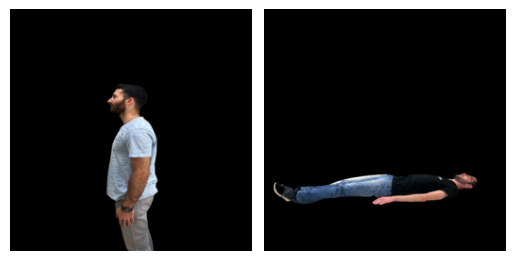

In [66]:
input,output = next(iter(train_loader))

print(input.shape)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot image1 in the first subplot
first = input.squeeze().permute(1,2,0)
second = output.squeeze().permute(1,2,0)
axs[0].imshow(first)
axs[0].axis('off')

# Plot image2 in the second subplot
axs[1].imshow(second)
axs[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# Display the figure
plt.show()

In [67]:
save = output

In [68]:
model.eval()
with torch.no_grad():
  output = model(input)

In [69]:
output.shape

torch.Size([1, 3, 256, 256])

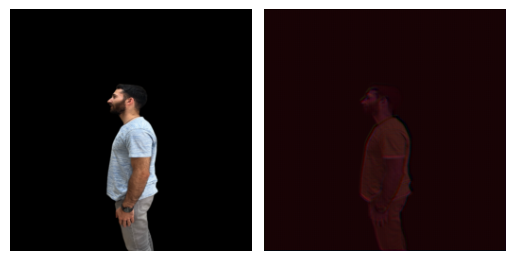

In [70]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2)

# Plot image1 in the first subplot
first = input.squeeze().permute(1,2,0)
second = output.squeeze().permute(1,2,0)
axs[0].imshow(first)
axs[0].axis('off')

# Plot image2 in the second subplot
axs[1].imshow(second)
axs[1].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# Display the figure
plt.show()

In [61]:


outputs = cnn(output)
probabilities = torch.softmax(outputs, dim=1)
_, predicted = torch.max(outputs, dim=1)
print(probabilities)
print(predicted[0])

tensor([[0.3132, 0.6868]], grad_fn=<SoftmaxBackward0>)
tensor(1)


In [62]:
print(crit(output,save))

tensor(0.7129)


In [18]:
class PostureNet(nn.Module):
    def __init__(self):
        super(PostureNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * (256 // 4) * (256 // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x
